In [16]:
import pandas as pd
from pandas import DataFrame
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cp
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

In [17]:
df = pd.read_csv("crsp_nflx.csv", parse_dates=["date"])
df.sort_values("date", inplace=True)
df.reset_index(drop=True, inplace=True)
df = df.dropna(subset=["PRC"])

In [124]:
window_length = 100
start_index = 50 
df_window = df.iloc[start_index:start_index + window_length + 1].copy()
T = window_length

In [125]:
prices = df_window["PRC"].values  # length T+1
dates = df_window["date"].values

#### Construct multiple alpha signals and combine them

In [126]:
# Signal 1: Based on a forward return (e.g., 5-day forward return, smoothed).

forecast_horizon = 5
smoothing_window = 5
df_window["raw_alpha1"] = (df_window["PRC"].shift(-forecast_horizon) / df_window["PRC"] - 1)
df_window["alpha1"] = df_window["raw_alpha1"].rolling(smoothing_window, min_periods=1).mean()
df_window["alpha1"].fillna(method="ffill", inplace=True)

# Signal 2: For example, create a periodic (non-monotonic) signal.
df_window["alpha2"] = 0.02 * np.sin(np.linspace(0, 4*np.pi, len(df_window)))

# To simulate realistic alpha, scale these signals down.
alpha_scale1 = 0.5
alpha_scale2 = 0.3
df_window["alpha1"] *= alpha_scale1
df_window["alpha2"] *= alpha_scale2

# Introduce decay rate (assume the non-monotic signal decays very slowly)
beta1 = 0.1
beta2 = 0.01
t = np.arange(len(df_window))
df_window["alpha1"] *= np.exp(-beta1 * t)
df_window["alpha2"] *= np.exp(-beta2 * t)

# Introduce delay for signal 1 (e.g. delay by 10 days)
delay_days = 20
df_window["alpha1"] = df_window["alpha1"].shift(delay_days)
df_window["alpha1"].fillna(0, inplace=True)

# Combined alpha: weighted sum of the two signals.
w1, w2 = 0.5, 0.5
df_window["alpha_combined"] = w1 * df_window["alpha1"] + w2 * df_window["alpha2"]

# Use the combined alpha for optimization.
alpha = df_window["alpha_combined"].values[:T+1]
delta_alpha = np.diff(alpha)  

In [127]:
# use a constant impact decay tau and a linear gamma_t

tau = 5.0  
w = 0.05   
penalty = 0.01 
Q_target = 100.0 
Q0 = 100.0      
J0 = 0.0      

gamma0 = 0.0
gammaT = 0.1 
gamma = np.linspace(gamma0, gammaT, T+1)
lambda_vals = np.exp(gamma) 

delta_gamma = np.diff(gamma)

In [128]:
# decision variable:
J = cp.Variable(T+1)

objective_terms = []

# sum from k=0 to T-1
for k in range(T):
    term_k = (np.exp(-gamma[k]) *
              ( J[k] * delta_alpha[k] 
                + (1/tau + delta_gamma[k]) * alpha[k] * J[k]
                - (1/tau) * (w * cp.square(J[k])) 
                - delta_gamma[k] * (0.5 * w * cp.square(J[k]) )
              )
             )
    objective_terms.append(term_k)
    
# terminal term at k=T:
terminal_term = np.exp(-gamma[T]) * (alpha[T] * J[T] - 0.5 * w * cp.square(J[T]))
objective_terms.append(terminal_term)

# deviation term:
position_increment = []
for i in range(T):
    position_increment.append((J[i+1] - (1 - 1/tau)*J[i]) / lambda_vals[i])
Q_T_expr = Q0 + cp.sum(cp.hstack(position_increment))
deviation = Q_target - Q_T_expr
penalty_term = - penalty * cp.square(deviation)

In [129]:
# full objective:
objective = cp.Maximize(cp.sum(cp.hstack(objective_terms)) + penalty_term)

constraints = [J[0] == J0]

# formulate problem
prob = cp.Problem(objective, constraints)

In [130]:
# solve problem 
try:
    prob.solve(solver=cp.SCS, verbose=True)
except Exception as e:
    print("Solver failed:", e)

print("Optimal value:", prob.value)
J_opt = J.value  # optimal J_t sequence

                                     CVXPY                                     
                                     v1.3.2                                    
(CVXPY) Mar 28 04:47:57 PM: Your problem has 101 variables, 1 constraints, and 0 parameters.
(CVXPY) Mar 28 04:47:57 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Mar 28 04:47:57 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Mar 28 04:47:57 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Mar 28 04:47:57 PM: Compiling problem (target solver=SCS).
(CVXPY) Mar 28 04:47:57 PM: Reduction chain: FlipObjective -> Dcp2Cone -> CvxAttr2Constr -> Cone

In [131]:
# recover portfolio position Q_t
Q_history = [Q0]
for i in range(T):
    delta_Q_i = (J_opt[i+1] - (1 - 1/tau)*J_opt[i]) / lambda_vals[i]
    Q_history.append(Q_history[-1] + delta_Q_i)
Q_history = np.array(Q_history)

## Plotting

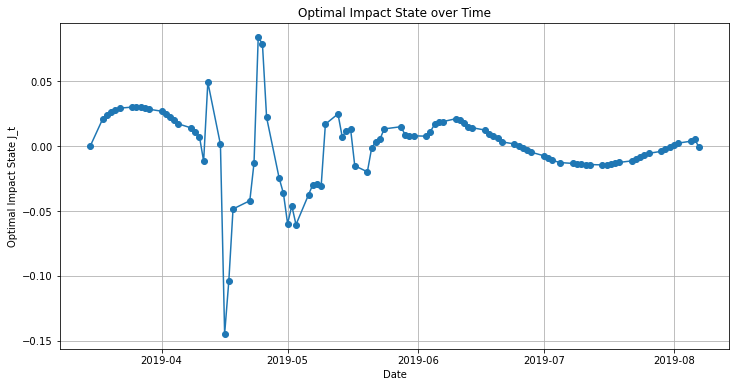

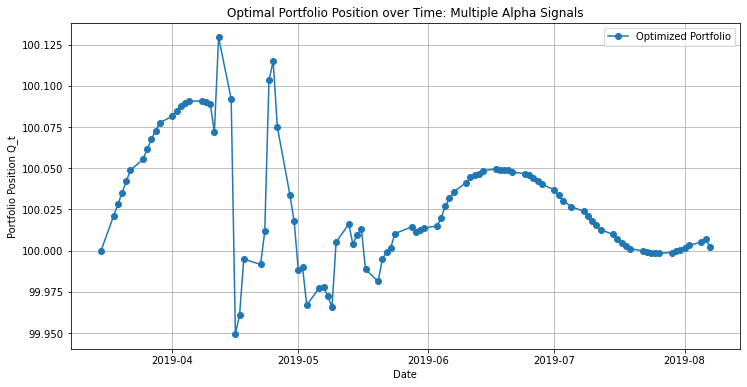

Final portfolio position: 100.00 (Target: 100.0)
Deviation from target: 0.00


In [134]:
dates = df_window["date"].values

plt.figure(figsize=(12,6))
plt.plot(dates, J_opt, marker='o')
plt.xlabel("Date")
plt.ylabel("Optimal Impact State J_t")
plt.title("Optimal Impact State over Time")
plt.grid(True)
plt.show()

plt.figure(figsize=(12,6))
plt.plot(dates, Q_history, marker='o', label="Optimized Portfolio")
plt.xlabel("Date")
plt.ylabel("Portfolio Position Q_t")
plt.title("Optimal Portfolio Position over Time: Multiple Alpha Signals")
plt.legend()
plt.grid(True)
plt.show()

# final metrics
final_Q = Q_history[-1]
print(f"Final portfolio position: {final_Q:.2f} (Target: {Q_target})")
print(f"Deviation from target: {abs(final_Q - Q_target):.2f}")